In [1]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import time

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

# Approach and Assumptions

To test the influence of the number of convolutional layers I will create multiple models with different amounts of layers and then analyze the performance of each one. 
To do this I'll define a function that takes in a set of layers (e.g. Conv2D + MaxPooling) and the amount of times that this set should be repeated. It returns a model with the specified convolutional layers.
For a baseline I will keep all non-convolutional layers and only add duplicate **Conv2D** layers, the **Dense** layers applied after the layers are flattened stay the same for all comparisons.

All hyperparameters besides the amount of layers are identical for all models and I since I specifically want to only see the impact of the **amount** of convolutional layers I assume I need to use the same set (but duplicated in different amounts) for all models. *For example: Adding Conv2D layers with different kernel sizes could improve the performance due to the kernel size instead of the extra layer itself.*

I assume that performance will greatly improve with the first few extra layers but then drop off when there are too many layers.
The inference time for predictions will probably rise consistently with each added layer. It is measured using a random entry from the dataset but the same one for all models by taking a simple timestamp before and after the prediction.

Below are the variables for the base layer set, the duplication step and the amount of models.

In [23]:
activation_conv = 'leaky_relu'  # LeakyReLU

# ! This should only include a single convolutional layer, the set functionality is only there to add pooling to each convolutional layer.
base_layer_set = [
    Conv2D(32, (5, 5), activation=activation_conv, padding='same'),
    MaxPooling2D(pool_size=(3, 3), padding='same'),
]
duplication_step = 1 # how many duplicate layers to add in each step
model_amnt = 15  # how many models to create

## helper function to load and parse annotations

In [3]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'../gesture_dataset_sample/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [4]:
# pretty-print first element
print(json.dumps(annotations['like']['0014182f-d756-42b3-896c-c52de76926bb'], indent=2))

{
  "bboxes": [
    [
      0.38056273,
      0.35650891,
      0.17322347,
      0.10461114
    ]
  ],
  "labels": [
    "like"
  ],
  "landmarks": [
    [
      [
        0.5497169170918876,
        0.4276043615779976
      ],
      [
        0.5218336293004483,
        0.40536586667786917
      ],
      [
        0.48288133220125257,
        0.3930262243722419
      ],
      [
        0.4501841862302019,
        0.37981099195030416
      ],
      [
        0.44251365410099686,
        0.36620499322043343
      ],
      [
        0.43138297470865106,
        0.406093902776592
      ],
      [
        0.4072660997339628,
        0.4073950234480344
      ],
      [
        0.42588200316326846,
        0.40612291879594015
      ],
      [
        0.4441470003072778,
        0.4049221293588555
      ],
      [
        0.4314493576491367,
        0.4212979654419442
      ],
      [
        0.42096276272263283,
        0.4180224457320293
      ],
      [
        0.43966095717106257,
      

## helper function to pre-process images (color channel conversion and resizing)

In [5]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [6]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'../gesture_dataset_sample/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'../gesture_dataset_sample/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

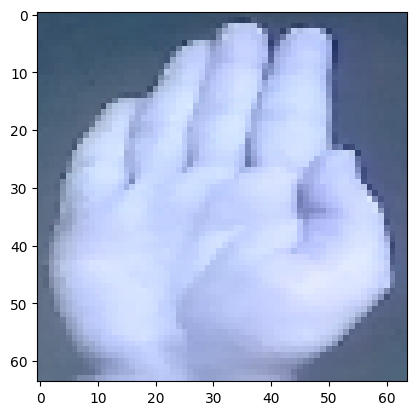

In [7]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [9]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


In [10]:
def create_model(layer_set, duplication_factor):
    """ Create a sequential model for gesture recognition.
    
    Returns the model, its summary, and the total number of layers."""
        
    # variables for hyperparameters
    num_classes = len(label_names)
    activation = 'relu'
    layer_count = 2
    num_neurons = 64

    # define model structure
    # with keras, we can use a model's add() function to add layers to the network one by one
    model = Sequential()

    # data augmentation (this can also be done beforehand - but don't augment the test dataset!)
    model.add(RandomFlip('horizontal'))
    model.add(RandomContrast(0.1))
    #model.add(RandomBrightness(0.1))
    #model.add(RandomRotation(0.2))

    model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))
    
    for factor in range(1, duplication_factor + 1):
        for i, layer in enumerate(layer_set):
            # Create a copy of the layer because keras layers are stateful
            config = layer.get_config()
            weights = layer.get_weights()
            layer_copy = type(layer).from_config(config)
            layer_copy.set_weights(weights)
            layer_copy.name = '_'.join(layer.name.split('_')[:-1]) + f'_{(factor) * (i + 1)}'
            model.add(layer_copy)

    # dropout layers can drop part of the data during each epoch - this prevents overfitting
    model.add(Dropout(0.2))

    # after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
    model.add(Flatten())

    # add some fully connected layers ("Dense")
    for i in range(layer_count - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(num_neurons, activation=activation))

    # for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
    model.add(Dense(num_classes, activation='softmax'))

    # specify loss function, optimizer and evaluation metrics
    # for classification, categorial crossentropy is used as a loss function
    # use the adam optimizer unless you have a good reason not to
    model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return {
        'model': model,
        'conv_layer_count': duplication_factor + 1,  # +1 because of the first conv layer before the duplication
    }

    

## now, we can train the model using the fit() function
## this will take a while

In [27]:
batch_size = 8
epochs = 50

model_data = [create_model(base_layer_set, factor * duplication_step) for factor in range(1, model_amnt + 1)]

# Select a single random sample from the test set (but always the same one)
np.random.seed(42)
sample_idx = np.random.randint(0, X_test.shape[0])
inference_sample = X_test[sample_idx:sample_idx+1]

for data in model_data:
    print(f"Training model with {data['conv_layer_count']} convolutional layers...", end='\r')

    data['history'] = data['model'].fit(
        X_train,
        train_label,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        validation_data=(X_test, test_label),
        callbacks=[
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001), 
            EarlyStopping(monitor='val_loss', patience=5)
        ]
    )
    
    # Log only the last epoch's metrics
    last_epoch = len(data['history'].history['loss']) - 1
    data['val_accuracy'] = data['history'].history['val_accuracy'][-1]

    # Measure inference time for a single prediction (same sample for all models)
    start_time = time.time()
    _ = data['model'].predict(inference_sample, verbose=0)
    end_time = time.time()
    inference_time = end_time - start_time
    data['inference_time'] = inference_time
    
    print(
        f"{data['conv_layer_count']} convolutional layers - "
        f"Epochs: {last_epoch + 1}/{epochs} - "
        f"Loss: {data['history'].history['loss'][last_epoch]:.4f}, "
        f"Val Loss: {data['history'].history['val_loss'][last_epoch]:.4f}, "
        f"Accuracy: {data['history'].history['accuracy'][last_epoch]:.4f}, "
        f"Val Accuracy: {data['history'].history['val_accuracy'][last_epoch]:.4f}, "
        f"Inference Time: {data['inference_time'] * 1000:.2f} ms"
    )
    


2 convolutional layers - Epochs: 13/50 - Loss: 0.2184, Val Loss: 0.2612, Accuracy: 0.9199, Val Accuracy: 0.9375, Inference Time: 88.90 ms
3 convolutional layers - Epochs: 21/50 - Loss: 0.1754, Val Loss: 0.3047, Accuracy: 0.9492, Val Accuracy: 0.9141, Inference Time: 92.46 ms
4 convolutional layers - Epochs: 14/50 - Loss: 0.1357, Val Loss: 0.2958, Accuracy: 0.9570, Val Accuracy: 0.9141, Inference Time: 97.64 ms
5 convolutional layers - Epochs: 17/50 - Loss: 0.0582, Val Loss: 0.2990, Accuracy: 0.9805, Val Accuracy: 0.9062, Inference Time: 102.07 ms
6 convolutional layers - Epochs: 21/50 - Loss: 0.0977, Val Loss: 0.2748, Accuracy: 0.9707, Val Accuracy: 0.9219, Inference Time: 107.24 ms
7 convolutional layers - Epochs: 24/50 - Loss: 0.0576, Val Loss: 0.1993, Accuracy: 0.9785, Val Accuracy: 0.9453, Inference Time: 116.76 ms
8 convolutional layers - Epochs: 13/50 - Loss: 1.0563, Val Loss: 1.0673, Accuracy: 0.4160, Val Accuracy: 0.4141, Inference Time: 124.27 ms
9 convolutional layers - Epoch

## Plot accuracy and loss of the training process

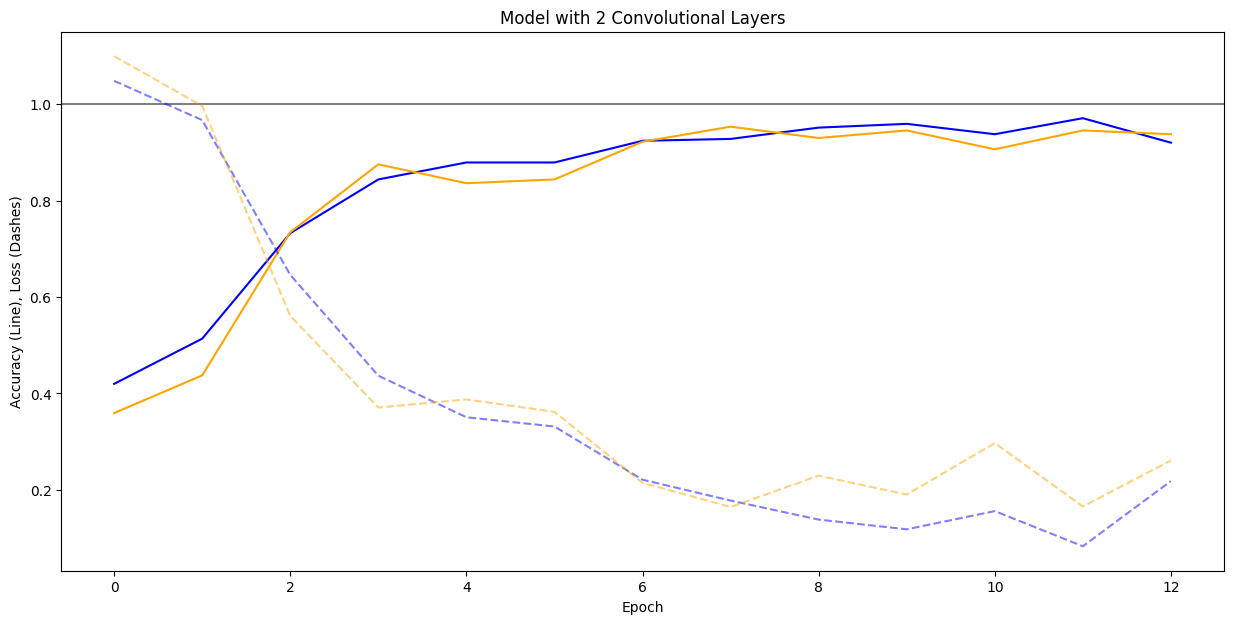

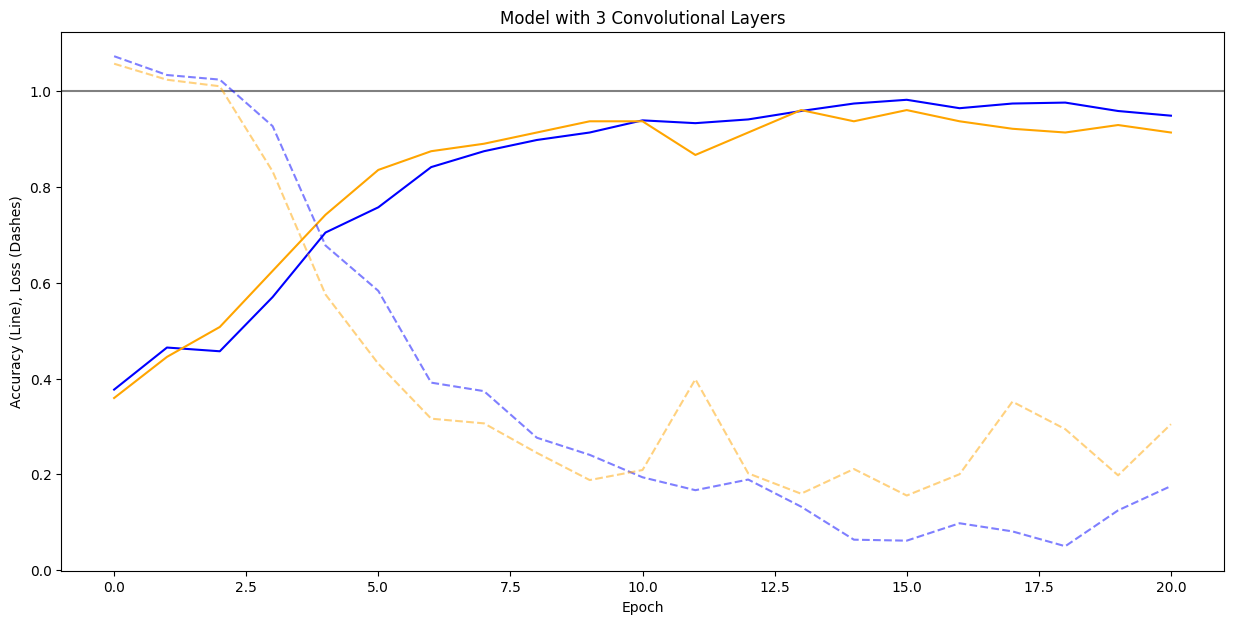

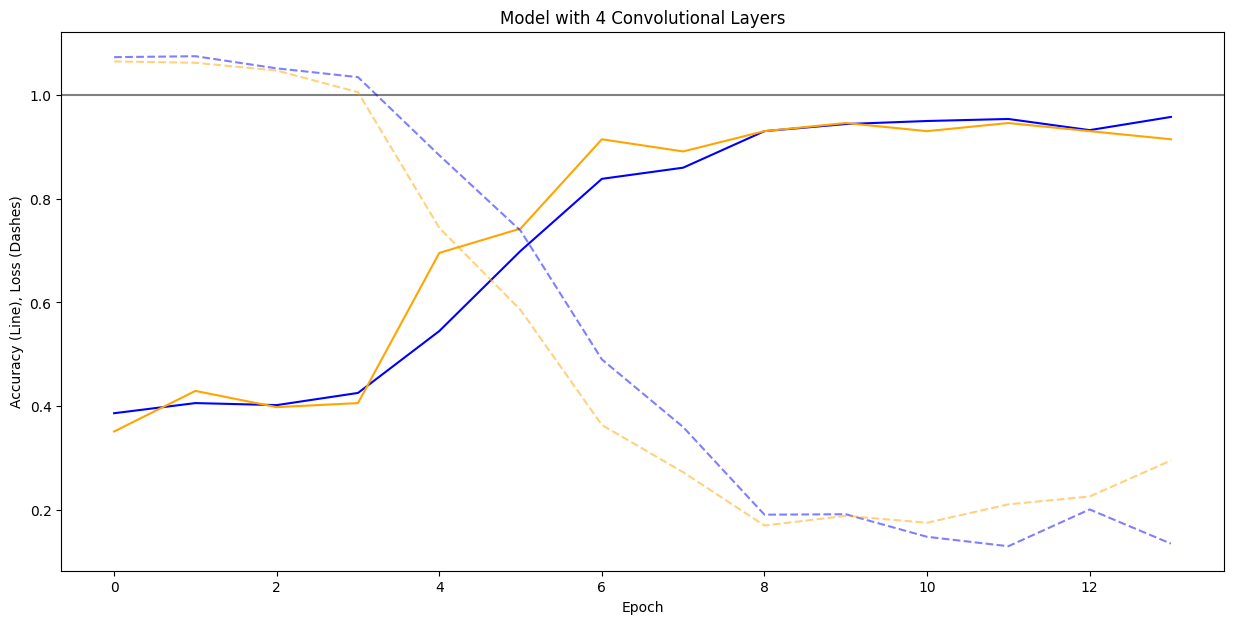

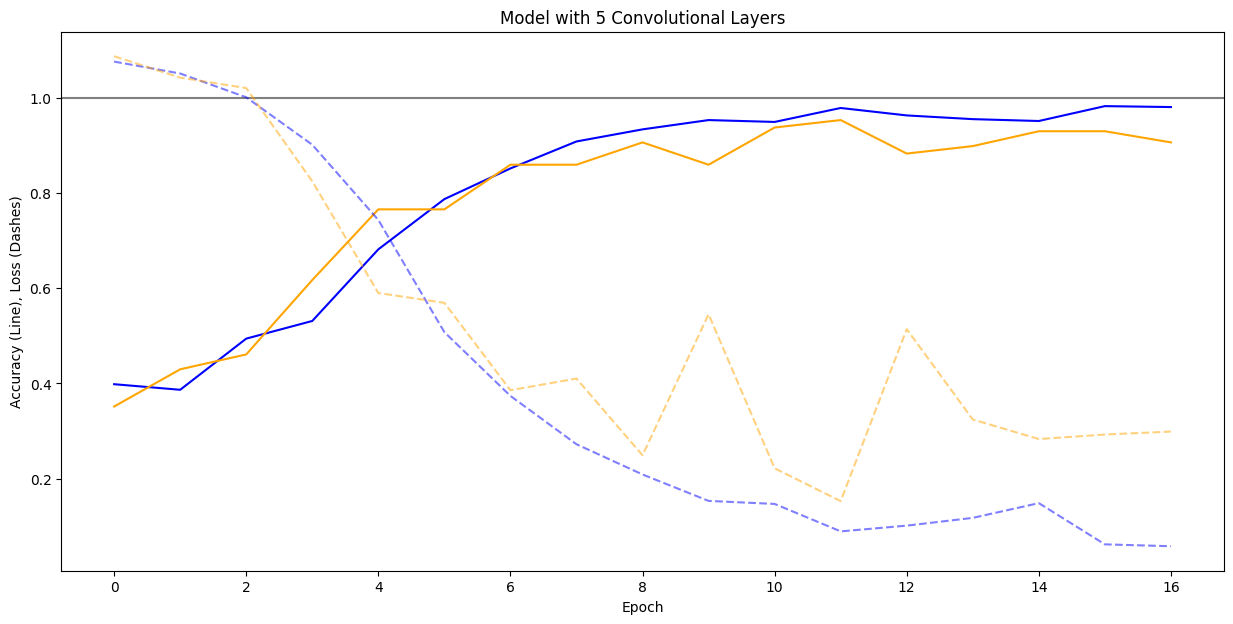

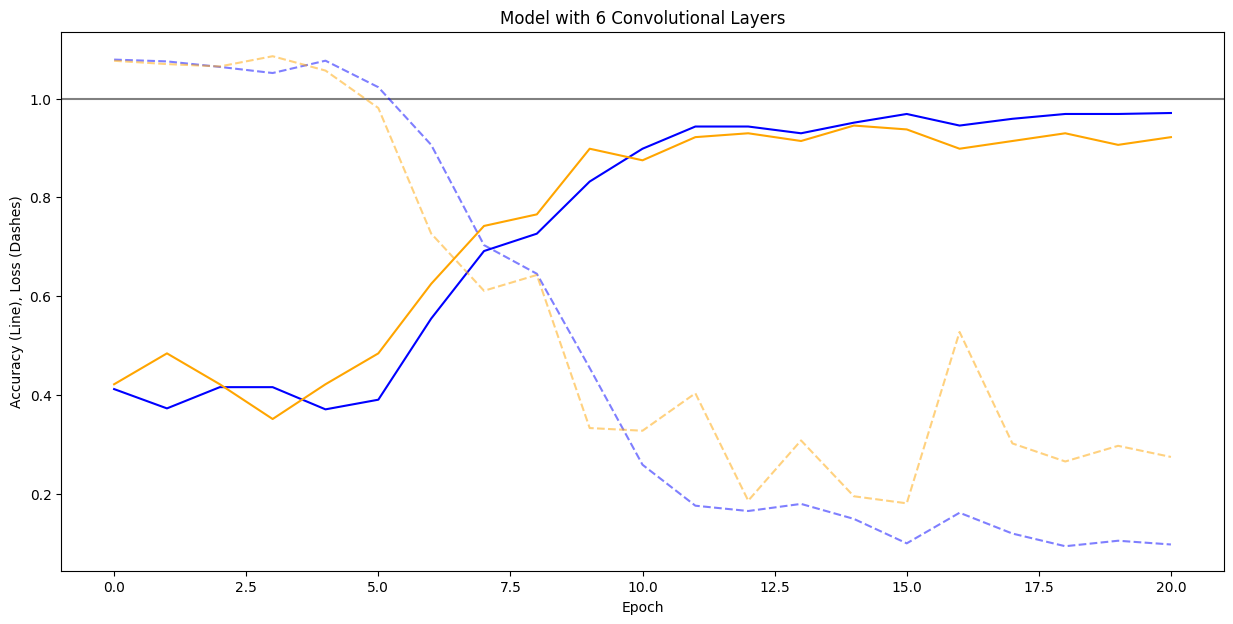

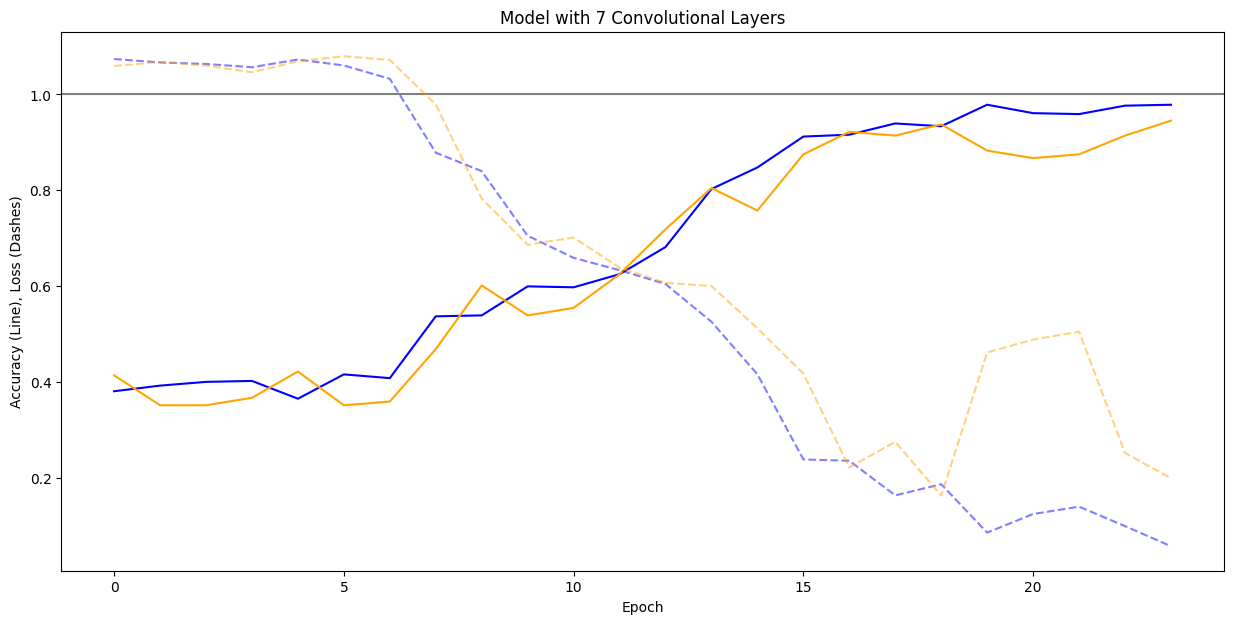

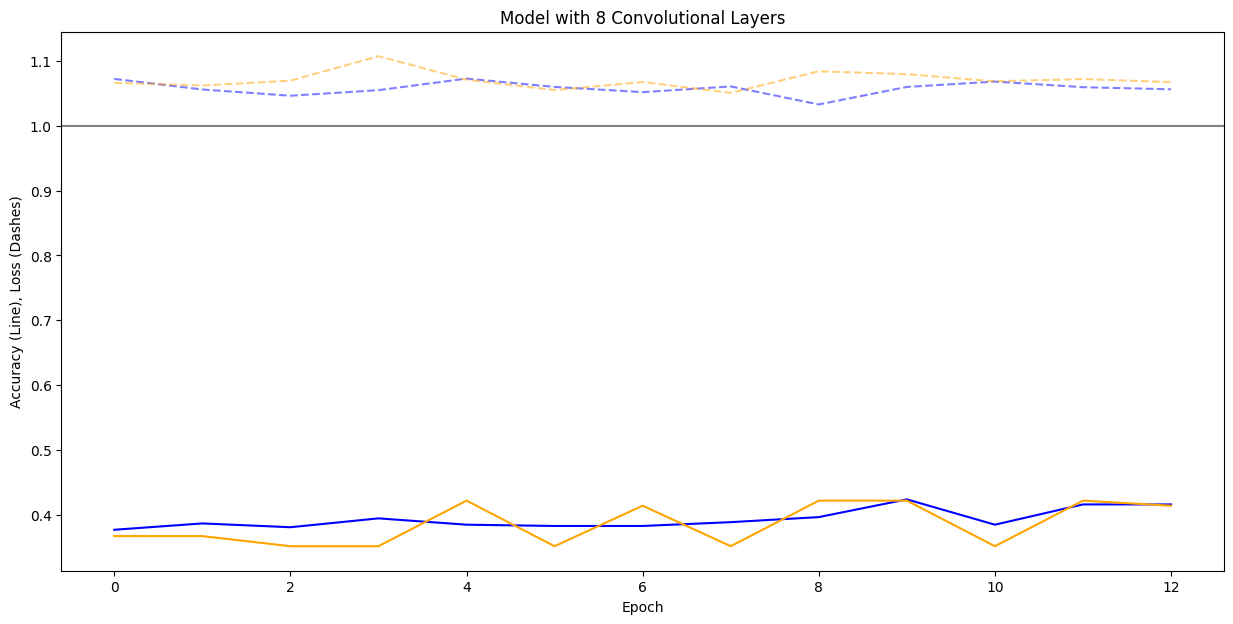

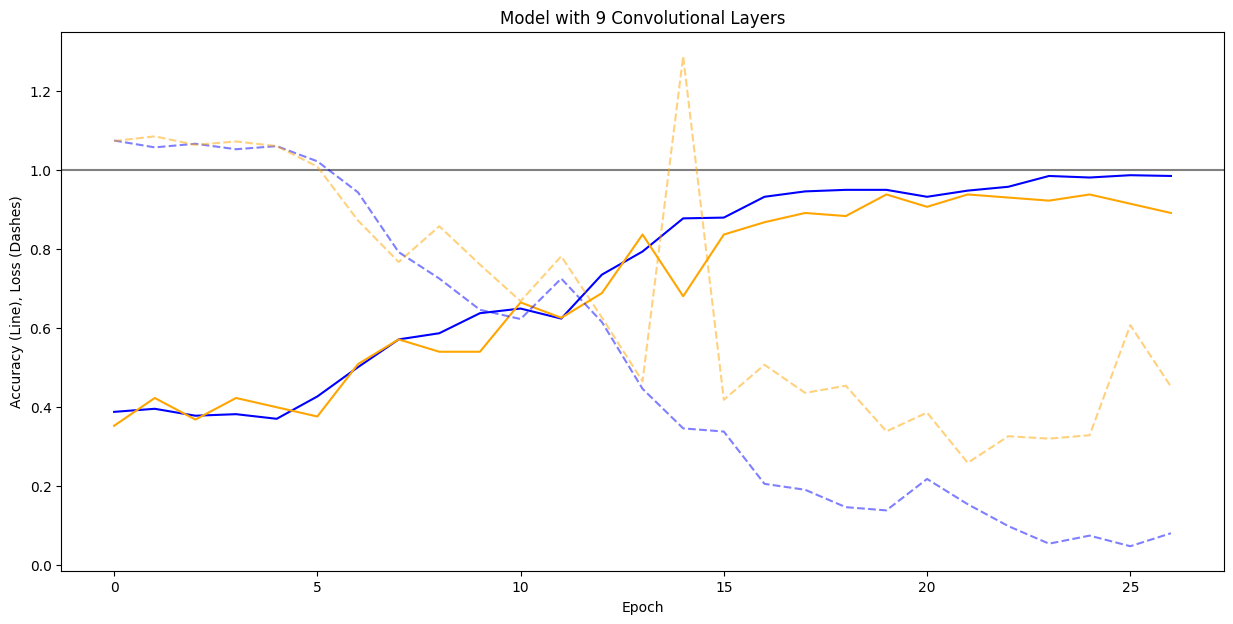

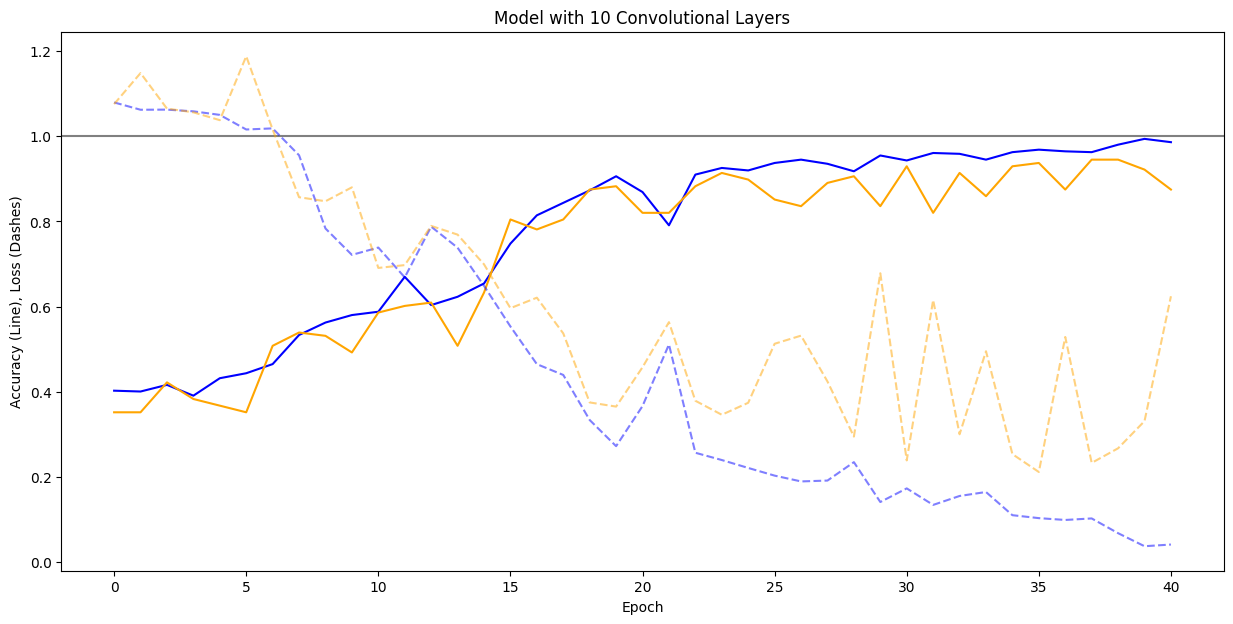

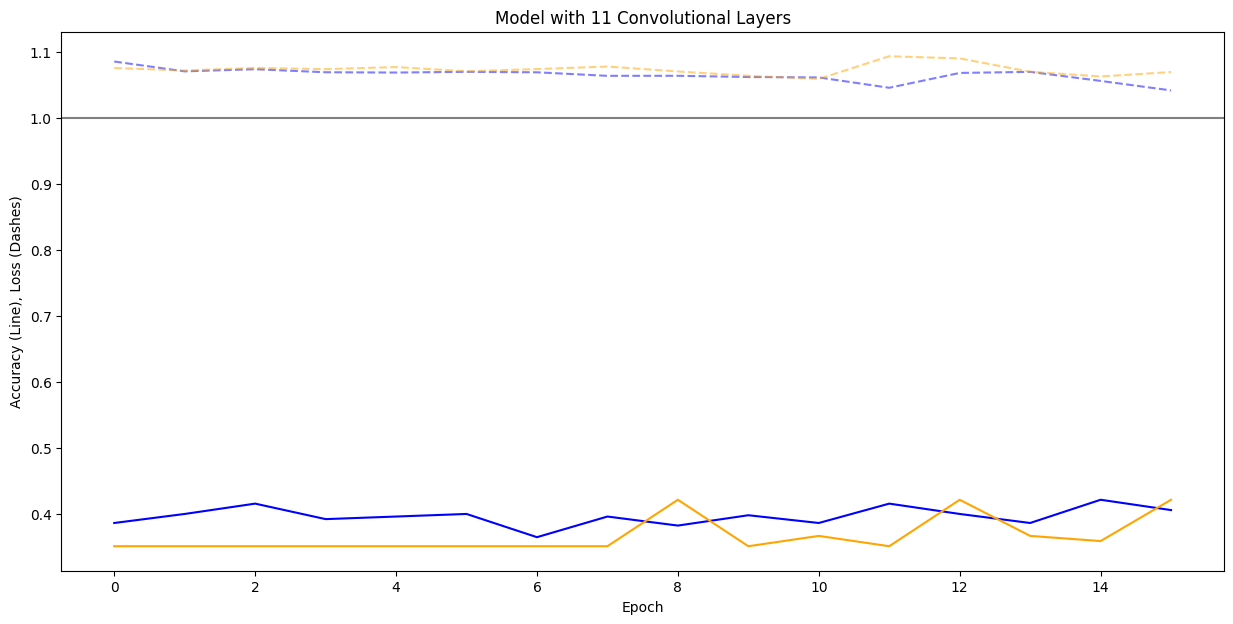

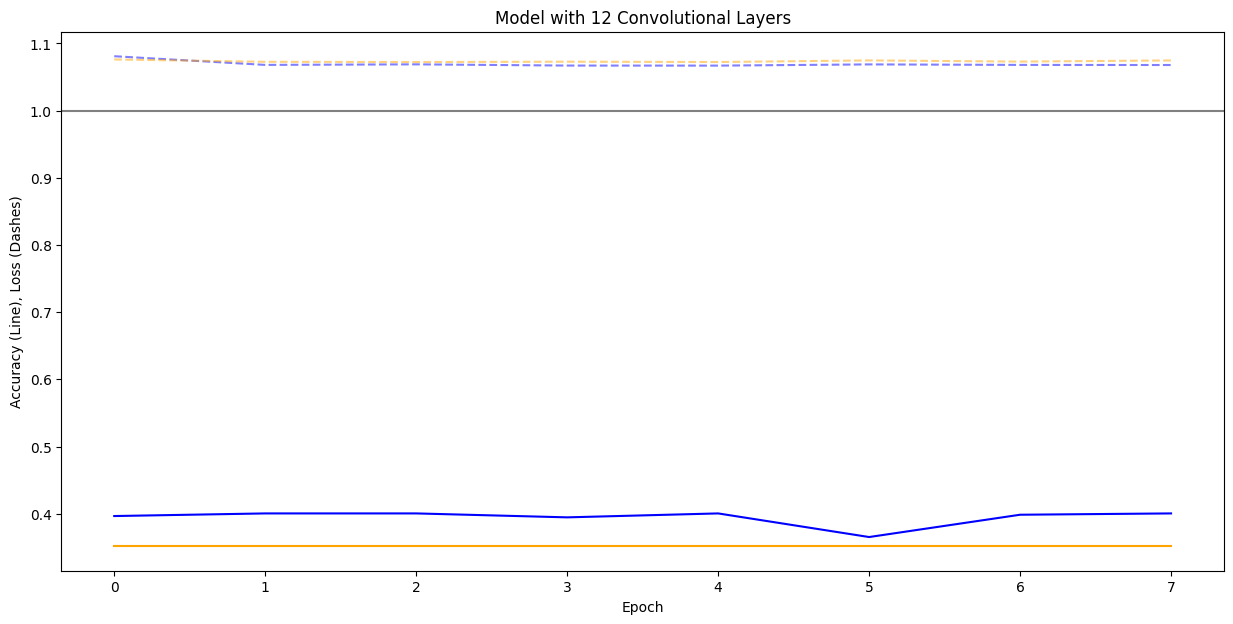

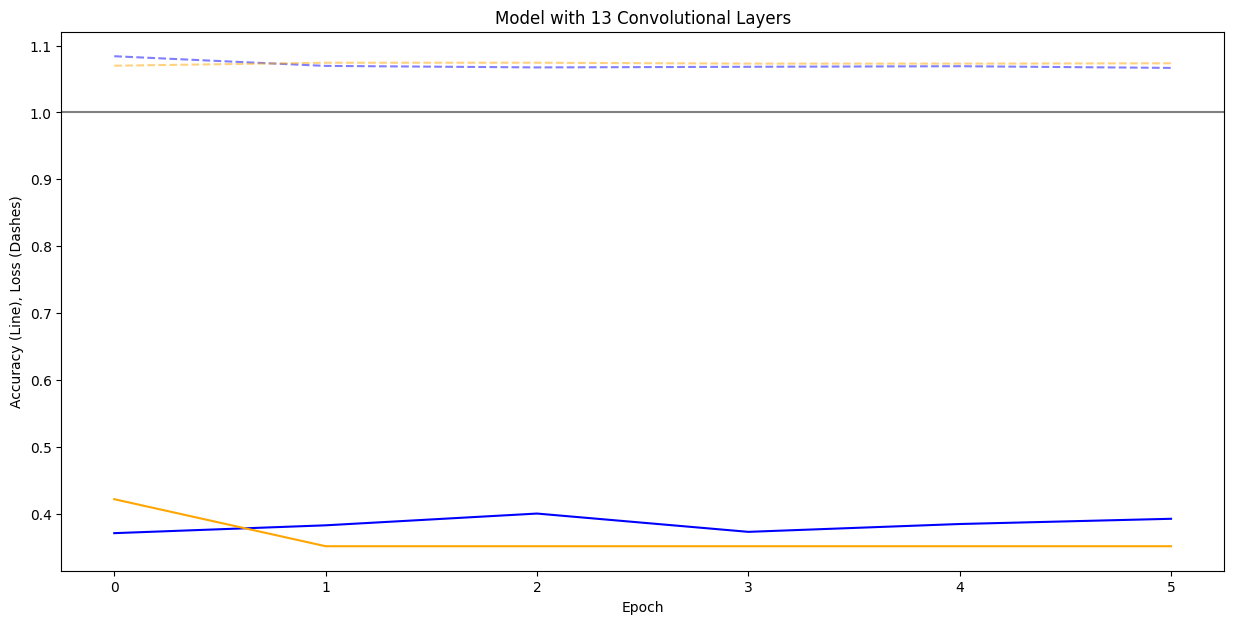

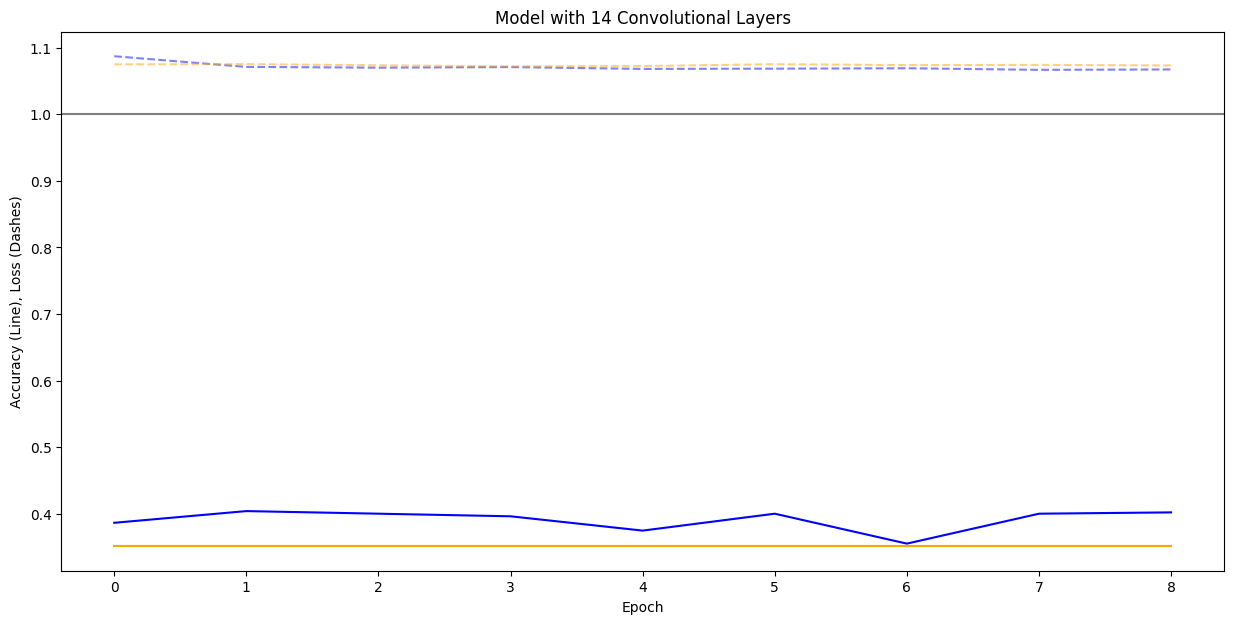

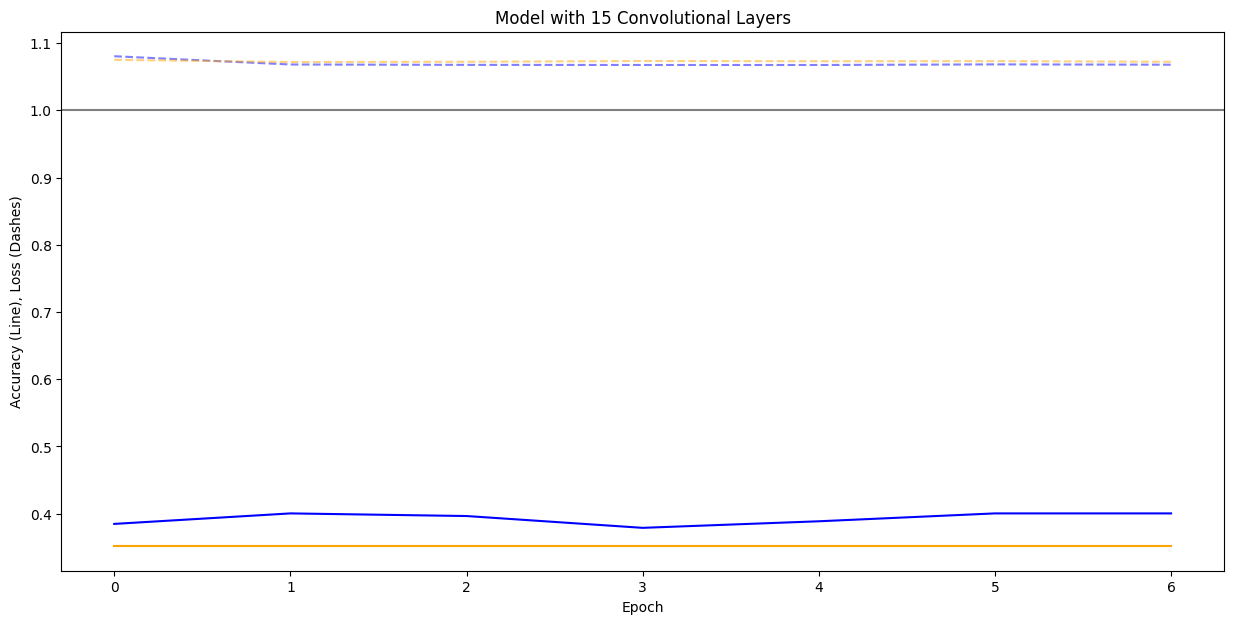

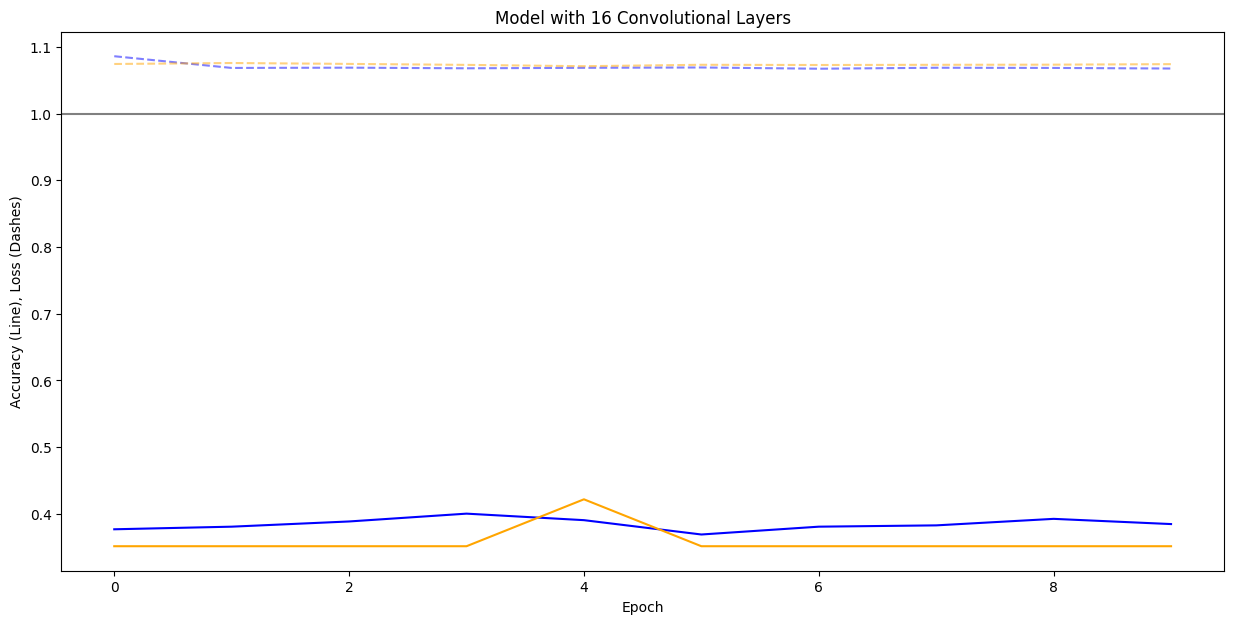

In [28]:
for data in model_data:
    history = data['history']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_title(f"Model with {data['conv_layer_count']} Convolutional Layers")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [29]:
#model.save('gesture_recognition.keras')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


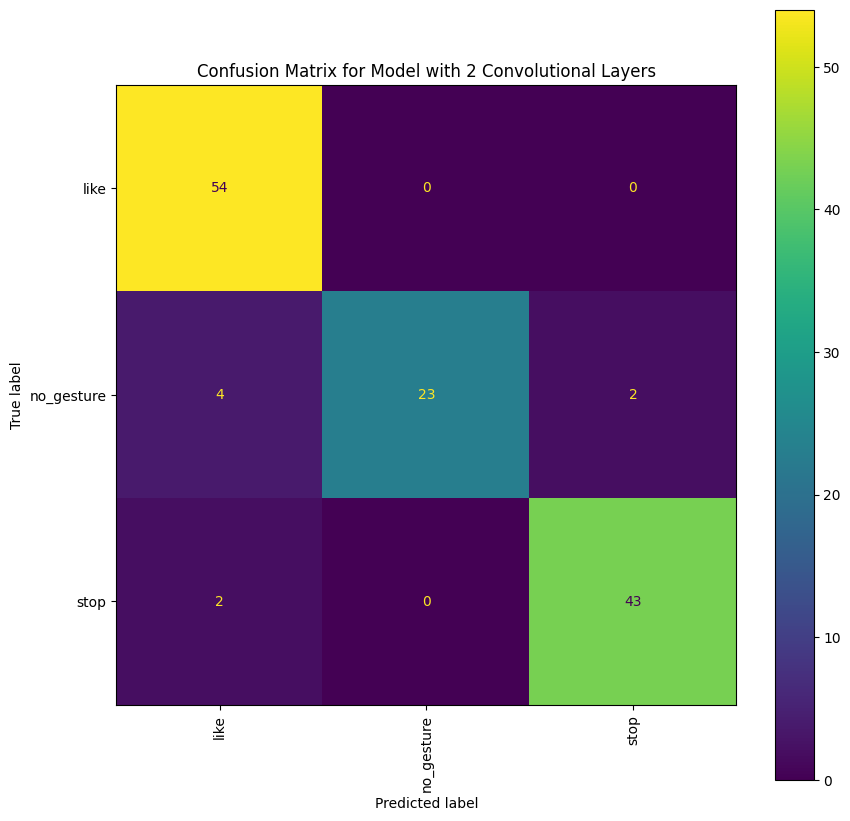

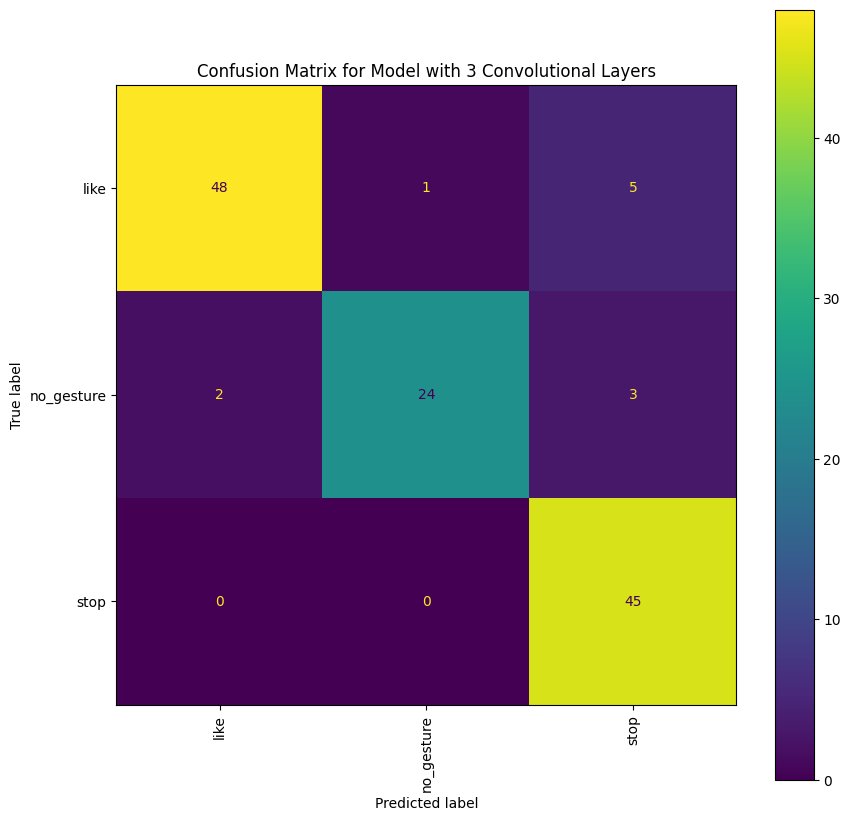

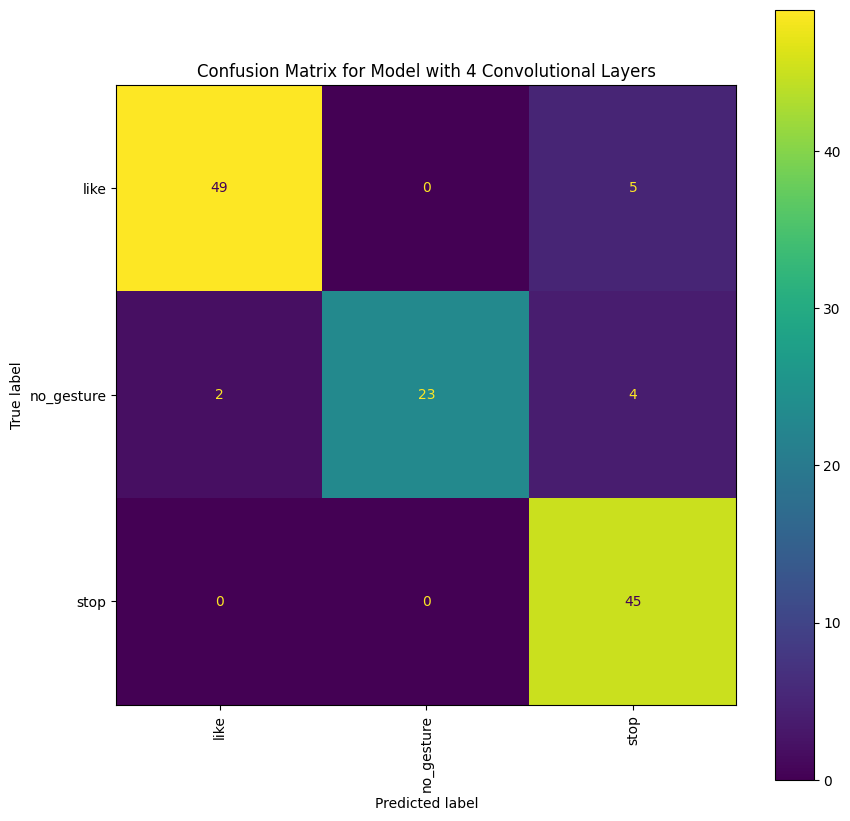

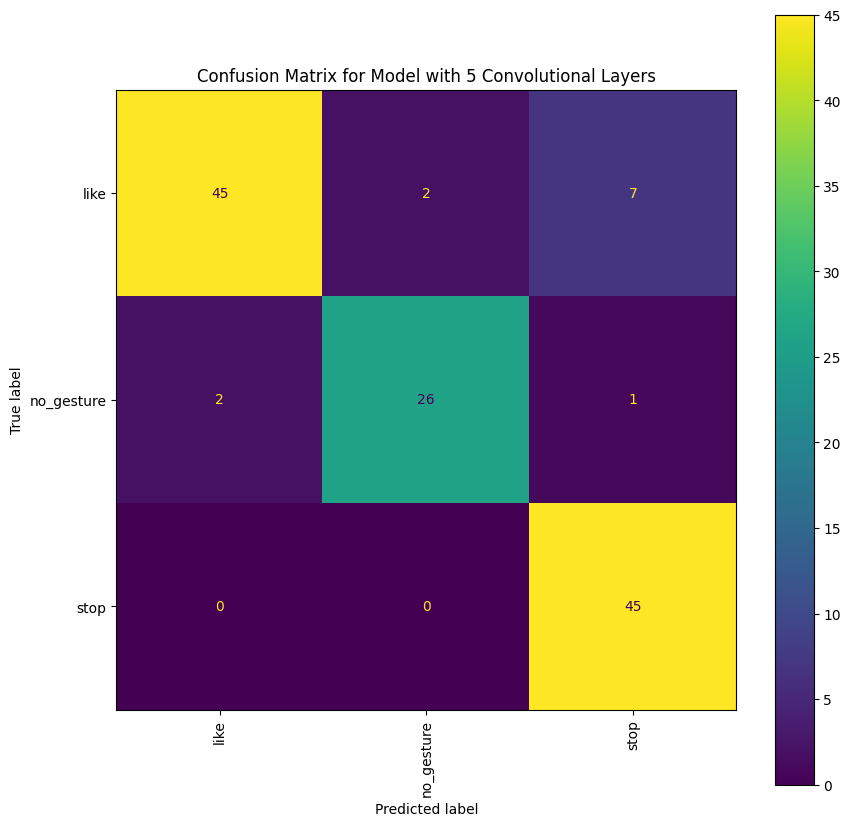

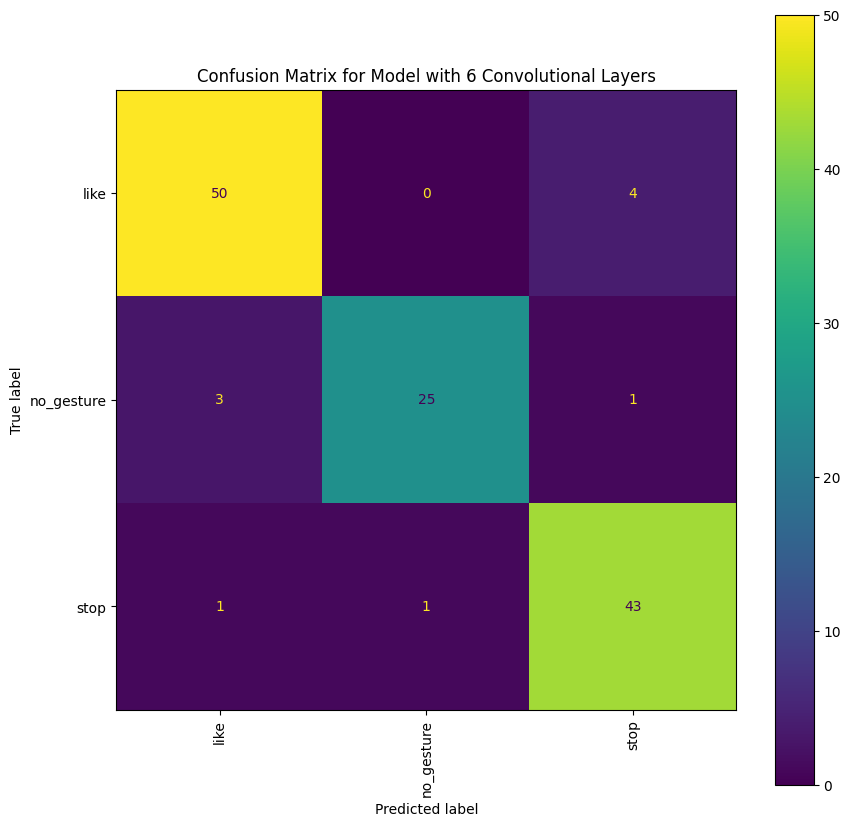

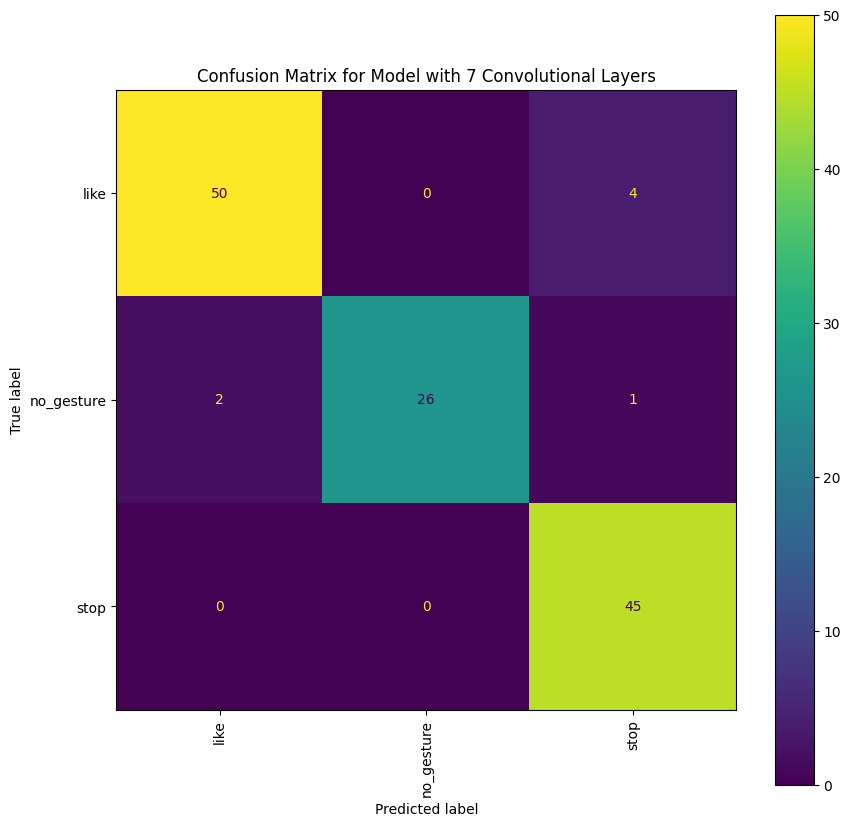

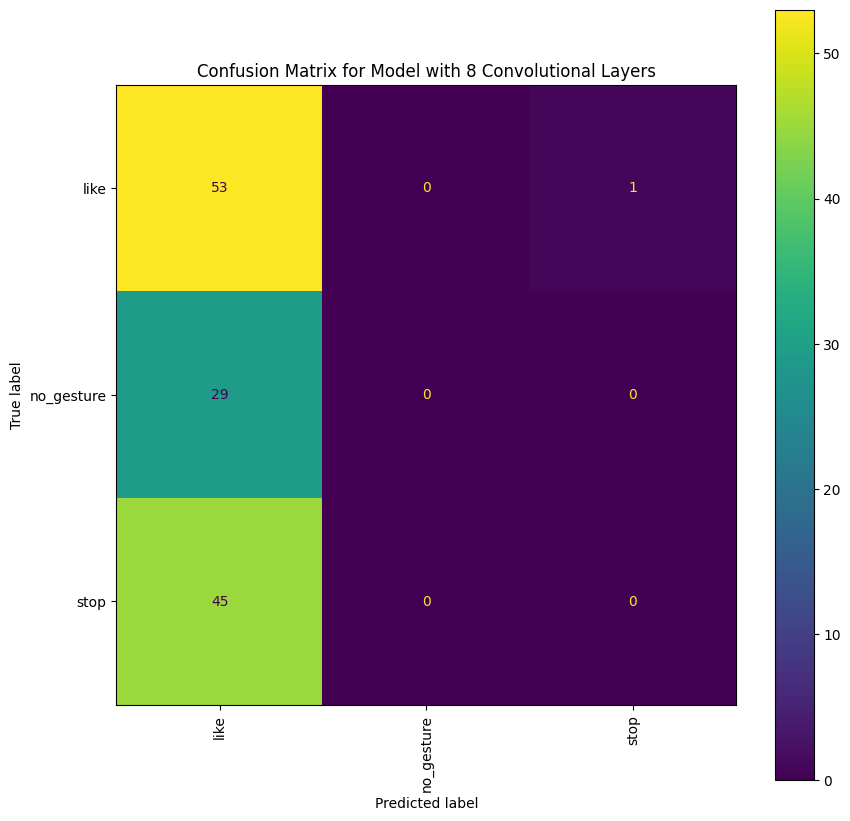

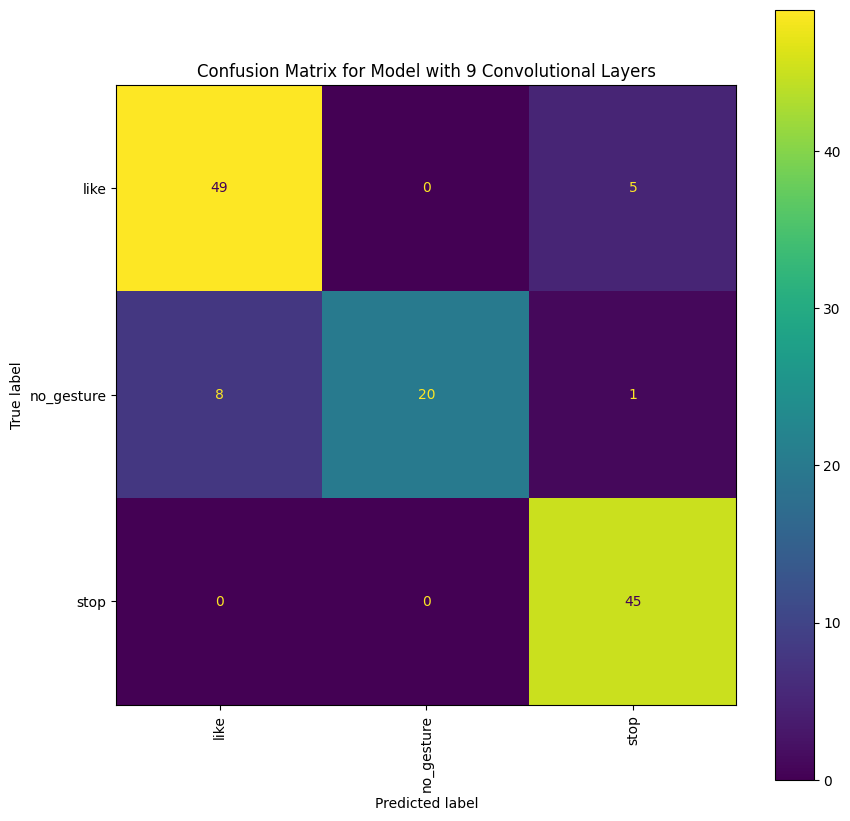

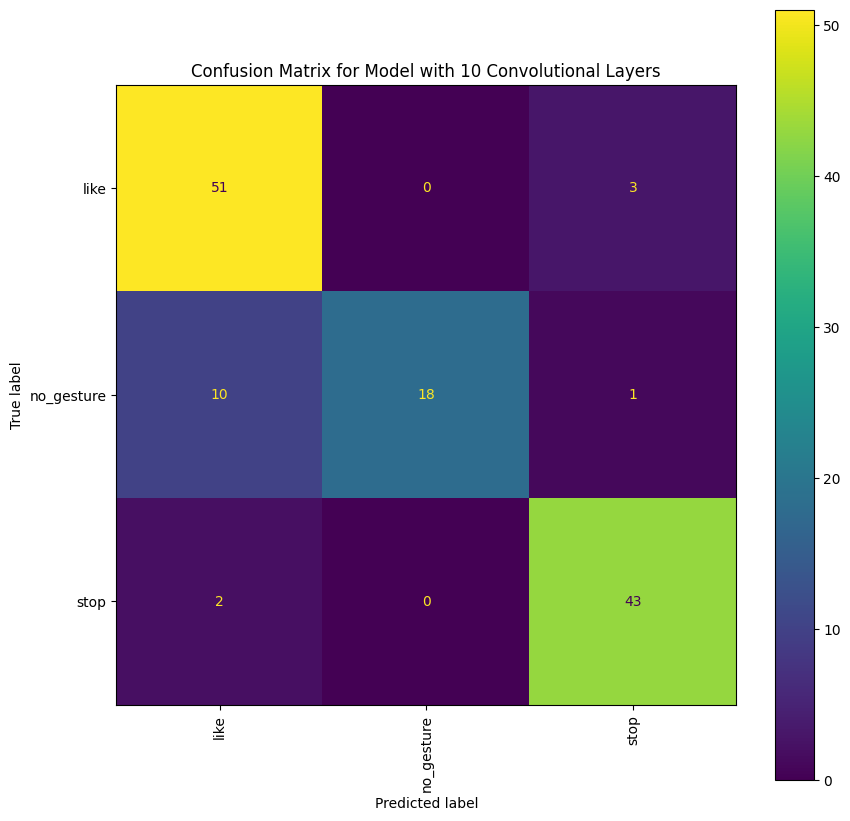

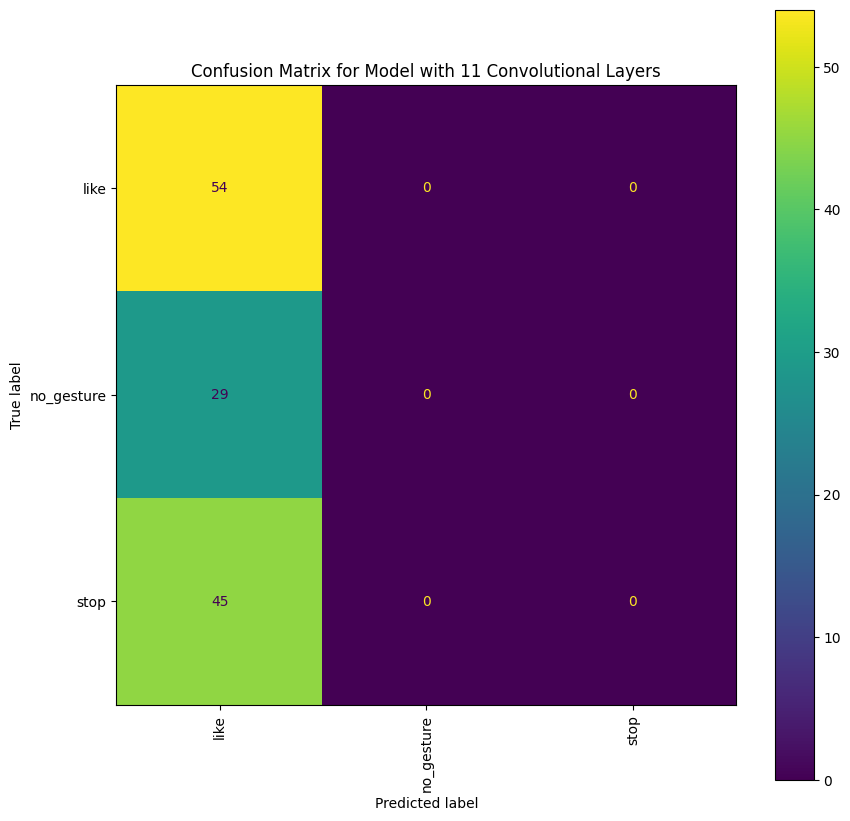

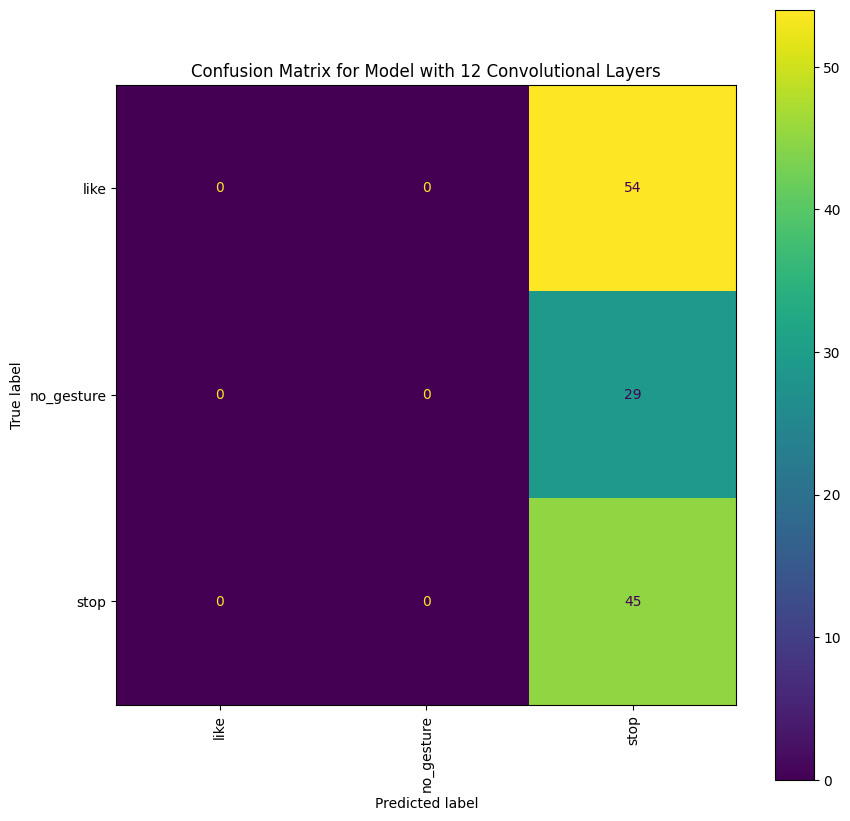

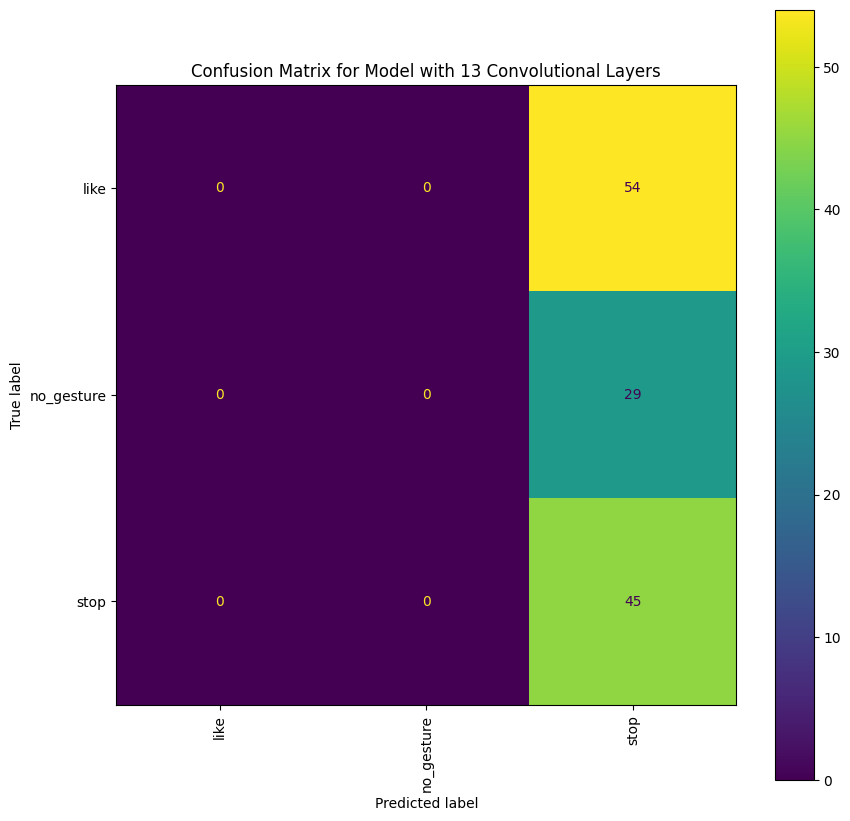

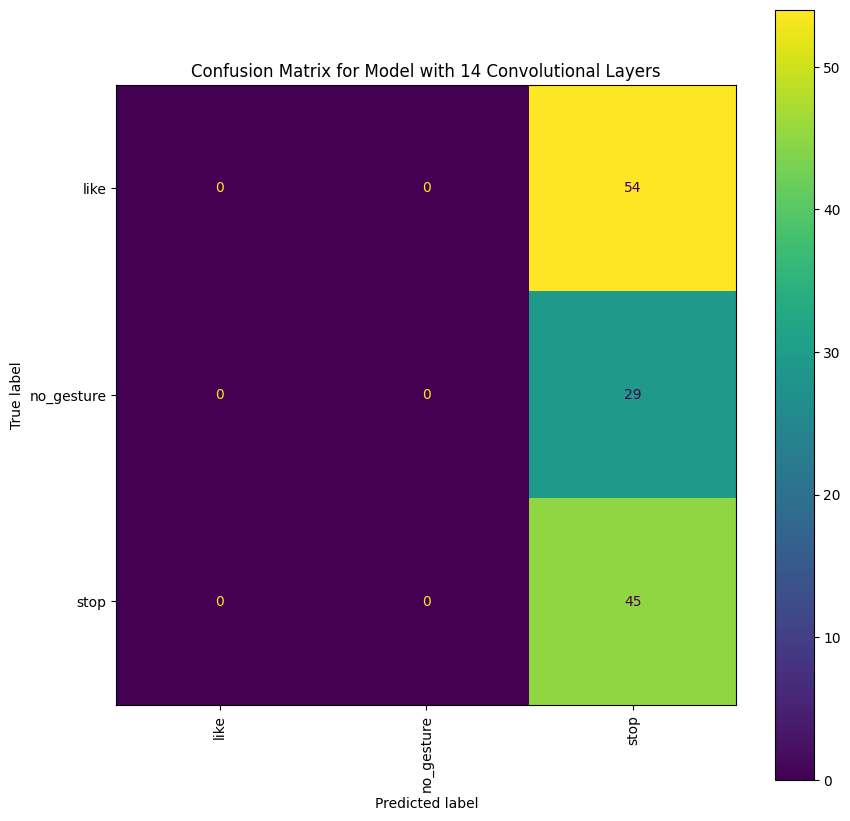

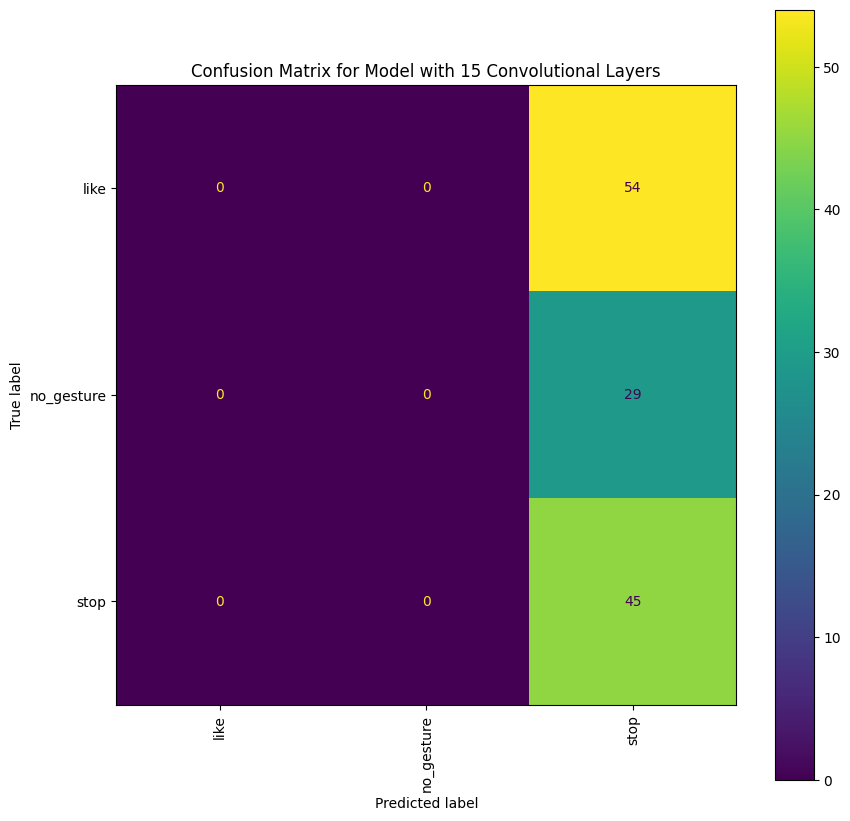

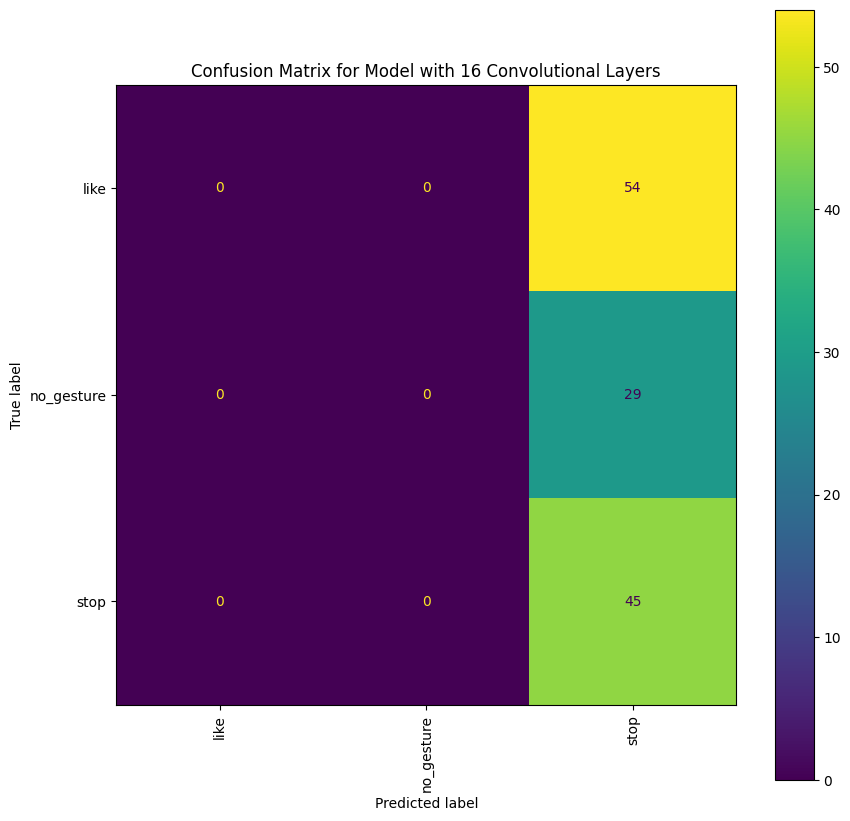

In [30]:
for data in model_data:
    model = data['model']    
    # let the model make predictions for our training data
    y_predictions = model.predict(X_test)

    # we get a 2D numpy array with probabilities for each category
    #print('before', y_predictions)

    # to build a confusion matrix, we have to convert it to classifications
    # this can be done by using the argmax() function to set the probability to 1 and the rest to 0
    y_predictions = np.argmax(y_predictions, axis=1)

    #print('probabilities', y_predictions)

    # create and plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_predictions)

    fig = plt.figure(figsize=(10, 10))

    ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

    plt.xticks(rotation=90, ha='center')
    plt.title(f'Confusion Matrix for Model with {data["conv_layer_count"]} Convolutional Layers')

# Findings

Below are plots comparing relevant values in the model data.

The data shows a significant abrupt drop off in accuracy at 11 layers confirming my assumption that too many layers would make the model worse.  
However I did not really see an improvement in the lower amounts, instead the accuracy seems to be pretty steady from the start.  
The amount of epochs before `EarlyStopping` triggered gradually increased with each additional layer and then also dropped significantly at 11 layers.  

Models with fewer conv layers needed very few epochs to reach their accuracy plateau while models with more conv layers took longer to reach their plateau.

The inference time plot indicates a small but consistent rise in inference time for predictions confirming my assumption that additional layers would increase the inference time.


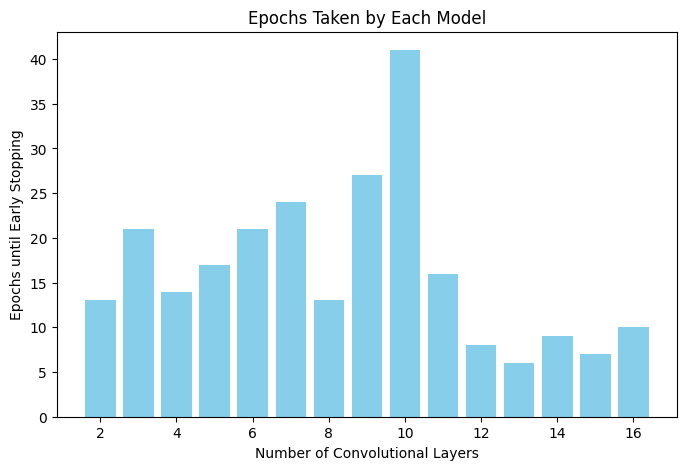

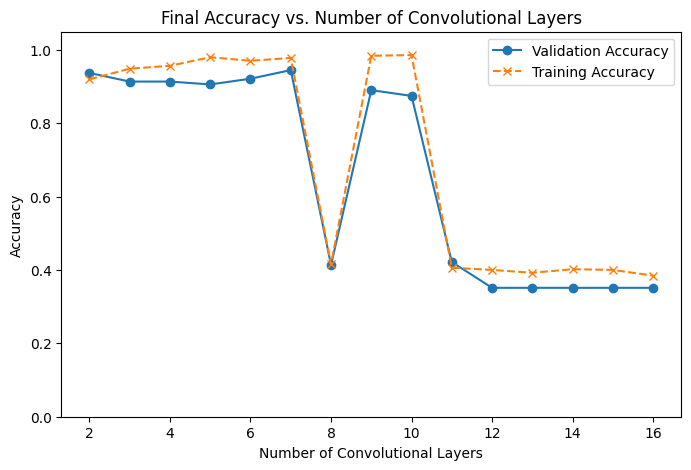

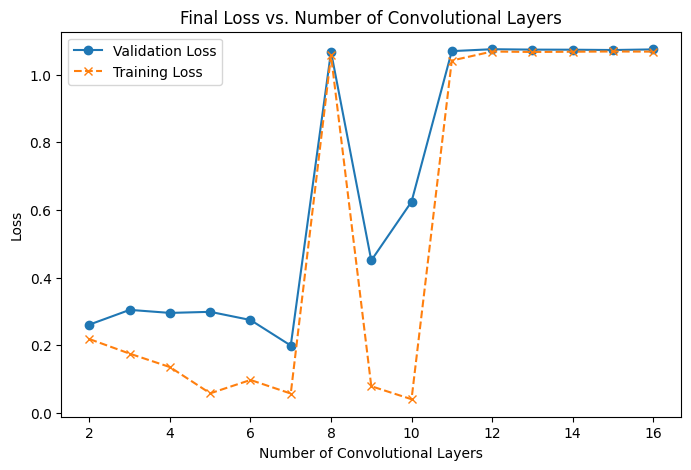

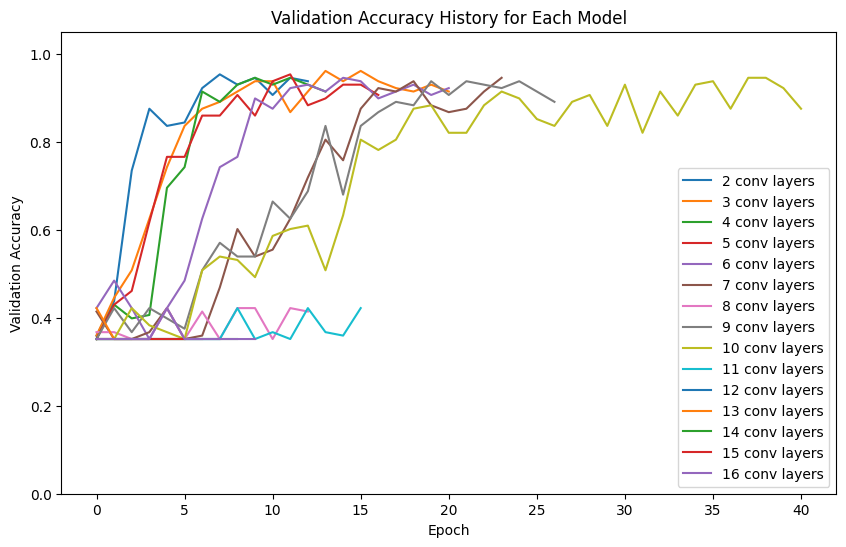

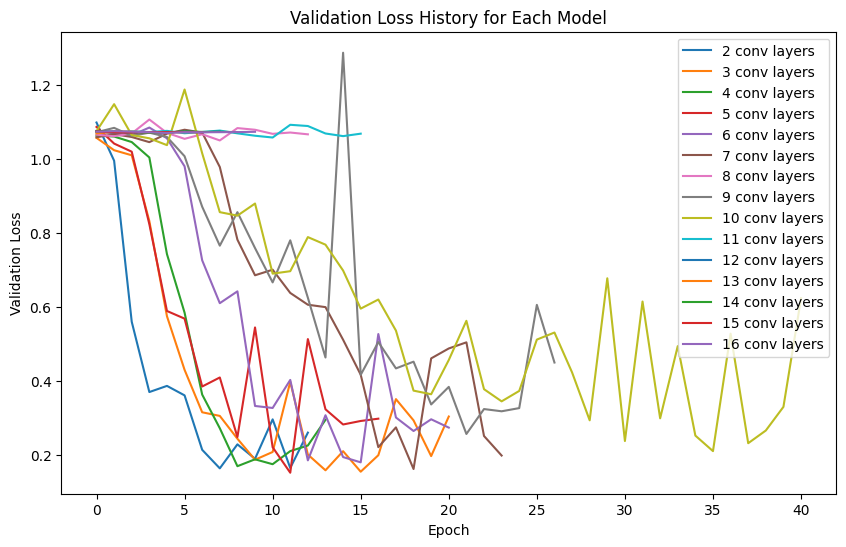

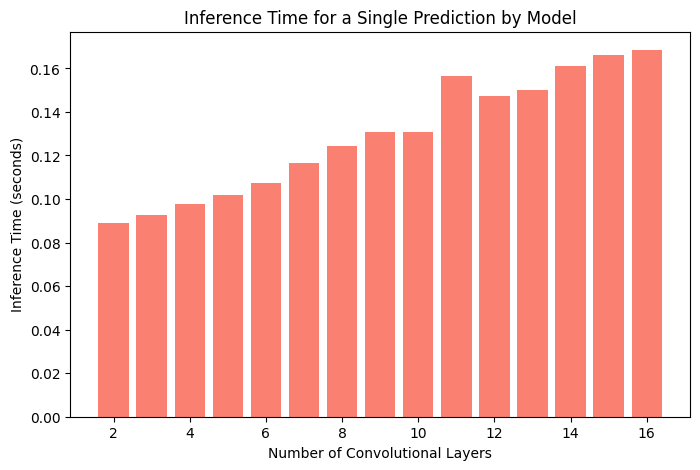

In [31]:
# Compare metrics for all models in model_data

# Extract metrics for each model
conv_layers = [data['conv_layer_count'] for data in model_data]
epochs_taken = [len(data['history'].history['loss']) for data in model_data]
final_val_accuracy = [data['history'].history['val_accuracy'][-1] for data in model_data]
final_val_loss = [data['history'].history['val_loss'][-1] for data in model_data]
final_train_accuracy = [data['history'].history['accuracy'][-1] for data in model_data]
final_train_loss = [data['history'].history['loss'][-1] for data in model_data]

# 1. Bar plot: Number of epochs each model took
plt.figure(figsize=(8, 5))
plt.bar(conv_layers, epochs_taken, color='skyblue')
plt.xlabel('Number of Convolutional Layers')
plt.ylabel('Epochs until Early Stopping')
plt.title('Epochs Taken by Each Model')
plt.show()

# 2. Line plot: Final validation accuracy vs. number of conv layers
plt.figure(figsize=(8, 5))
plt.plot(conv_layers, final_val_accuracy, marker='o', label='Validation Accuracy')
plt.plot(conv_layers, final_train_accuracy, marker='x', linestyle='--', label='Training Accuracy')
plt.xlabel('Number of Convolutional Layers')
plt.ylabel('Accuracy')
plt.title('Final Accuracy vs. Number of Convolutional Layers')
plt.legend()
plt.ylim(0, 1.05)
plt.show()

# 3. Line plot: Final validation loss vs. number of conv layers
plt.figure(figsize=(8, 5))
plt.plot(conv_layers, final_val_loss, marker='o', label='Validation Loss')
plt.plot(conv_layers, final_train_loss, marker='x', linestyle='--', label='Training Loss')
plt.xlabel('Number of Convolutional Layers')
plt.ylabel('Loss')
plt.title('Final Loss vs. Number of Convolutional Layers')
plt.legend()
plt.show()

# 4. Plot: Validation accuracy history for all models
plt.figure(figsize=(10, 6))
for data in model_data:
    plt.plot(data['history'].history['val_accuracy'], label=f"{data['conv_layer_count']} conv layers")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy History for Each Model')
plt.legend()
plt.ylim(0, 1.05)
plt.show()

# 5. Plot: Validation loss history for all models
plt.figure(figsize=(10, 6))
for data in model_data:
    plt.plot(data['history'].history['val_loss'], label=f"{data['conv_layer_count']} conv layers")
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss History for Each Model')
plt.legend()
plt.show()

# 6. Bar plot: Inference time for each model
plt.figure(figsize=(8, 5))
inference_times = [data['inference_time'] for data in model_data]
plt.bar(conv_layers, inference_times, color='salmon')
plt.xlabel('Number of Convolutional Layers')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time for a Single Prediction by Model')
plt.show()